In [1]:
import tensorflow as tf
import metrics
from datasets import seq2seq_generator
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mape = metrics.build_mape(overlap=6)
smape = metrics.build_smape(overlap=6)
mase = metrics.build_mase(overlap=6)
owa_estimate = metrics.build_owa(overlap=6)
reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

In [3]:
with open('../data/yearly_scales.pkl', 'rb') as f:
    scaler = pkl.load(f)

In [4]:
with open('../data/yearly_validation.pkl', 'rb') as f:
    x_test, y_test = pkl.load(f)
    
y_test = np.c_[x_test[:, -6:], y_test]

In [5]:
results = {'smape': {k: [] for k in range(12)},
           'mase': {k: [] for k in range(12)},
           'owa': {k: [] for k in range(12)},
           'reconstruction': {k: [] for k in range(12)},
           'mse': {k: [] for k in range(12)},
           }

for i in range(12):
    model_dir = 'results/' + str(i) + '/best_weights.h5'

    model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                  'MASE_estimate': mase,
                                                                  'OWA_estimate': owa_estimate,
                                                                  'reconstruction_loss': reconstruction_loss})
    print('\nEvaluating model', i+1)
    for ind in range(len(x_test) // 256):
        
        x = x_test[ind * 256 : (ind + 1) * 256, :, np.newaxis]
        y = y_test[ind * 256 : (ind + 1) * 256, :, np.newaxis]
       
        y_ = model(x)

        start_ind = 588782 + ind * 256
        try:
            batch_min = np.array([scaler[i][0] for i in range(start_ind, start_ind + 256)])[:, np.newaxis, np.newaxis]
            batch_max = np.array([scaler[i][1] for i in range(start_ind, start_ind + 256)])[:, np.newaxis, np.newaxis]
            batch_scale = batch_max - batch_min
        except IndexError:
            batch_scale = 1

        descaled_y = y * batch_scale + batch_min
        descaled_p = y_ * batch_scale + batch_min
        
        
        results['smape'][i].append(smape(tf.cast(descaled_y, tf.float32), descaled_p).numpy().mean())
        results['mase'][i].append(mase(tf.cast(descaled_y, tf.float32), descaled_p).numpy().mean())
        results['owa'][i].append(owa_estimate(tf.cast(descaled_y, tf.float32), descaled_p).numpy().mean())
        results['reconstruction'][i].append(reconstruction_loss(tf.cast(descaled_y, tf.float32), descaled_p).numpy().mean())
        results['mse'][i].append(tf.keras.metrics.mse(tf.cast(descaled_y, tf.float32), descaled_p).numpy().mean())

    for k, v in results.items():
        print(k, np.median(v[i]))


Evaluating model 1
smape 5.3431587
mase 2.0411959
owa 0.76945055
reconstruction 445.78162
mse 146849.12

Evaluating model 2
smape 5.3731923
mase 2.0104218
owa 0.77414143
reconstruction 1758.1492
mse 144984.03

Evaluating model 3
smape 5.3158464
mase 2.0363836
owa 0.7717435
reconstruction 478.1649
mse 143285.45

Evaluating model 4
smape 5.3291407
mase 2.0315757
owa 0.77638507
reconstruction 501.0088
mse 142706.0

Evaluating model 5
smape 5.3658214
mase 2.0291681
owa 0.7720751
reconstruction 632.9737
mse 142277.22

Evaluating model 6
smape 5.362952
mase 2.0316265
owa 0.7778505
reconstruction 2735.1802
mse 146648.52

Evaluating model 7
smape 5.328504
mase 2.027214
owa 0.7706969
reconstruction 525.5313
mse 142978.78

Evaluating model 8
smape 5.3547034
mase 2.0465217
owa 0.7713008
reconstruction 333.0329
mse 142096.97

Evaluating model 9
smape 5.3157654
mase 2.0391197
owa 0.77518076
reconstruction 417.05713
mse 145860.81

Evaluating model 10
smape 5.378541
mase 2.0337405
owa 0.7733648
reco

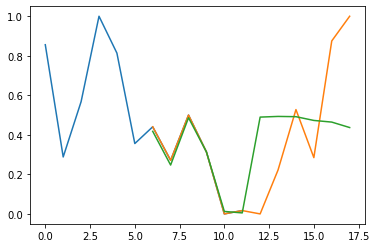

In [57]:
i = 152
preds = model(x_test[i][np.newaxis, ..., np.newaxis])
plt.plot(range(12), x_test[i, :])
plt.plot(range(6, 18), y_test[i, :])
plt.plot(range(6, 18), preds[0, :, 0])

In [58]:
x_test[i]

array([0.8559322 , 0.28813559, 0.56779661, 1.        , 0.81355932,
       0.3559322 , 0.44067797, 0.27118644, 0.5       , 0.31355932,
       0.        , 0.01694915])

In [13]:
y_ = model(x)

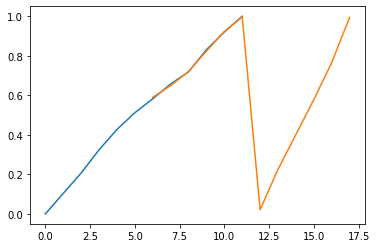

In [15]:
plt.plot(range(12), x[0, :, 0])
plt.plot(range(6, 18), y_[0, :, 0])